In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, confusion_matrix, recall_score, make_scorer

import xgboost as xgb
from sklearn.linear_model import LogisticRegression

## 1. EDA, data cleaning and feature engineering

### EDA

In [2]:
df = pd.read_csv('./breast_cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.shape

(569, 32)

In [4]:
df.isna().any(axis = 0)

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave_points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave_points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave_points_worst       False
symmetry_w

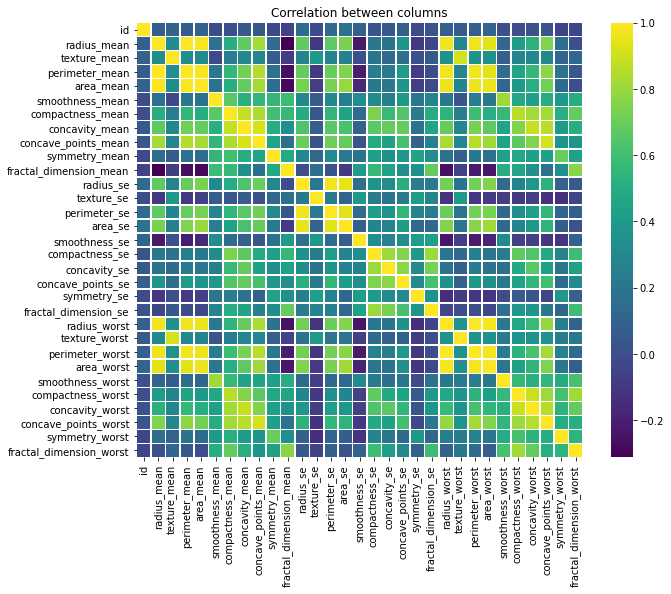

In [5]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', linewidths=0.5)
plt.title('Correlation between columns')
plt.show()

This dataset is cleaned with no missing data. However, as showned by the heatmap, some columns are highly intercorrelated. Since the colinarity and limited data size, I'm using pca to decrease the columns.

### Split train test data

In [6]:
# Prepare dataset for training
X = df.drop('diagnosis', axis=1)
y = pd.get_dummies(df['diagnosis'], drop_first=True).values.ravel()

In [7]:
# split train test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Scale data and do PCA

In [8]:
# Scale festures with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
threshold = 0.95
pca = PCA(n_components = threshold)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [10]:
X_train_pca.shape

(455, 11)

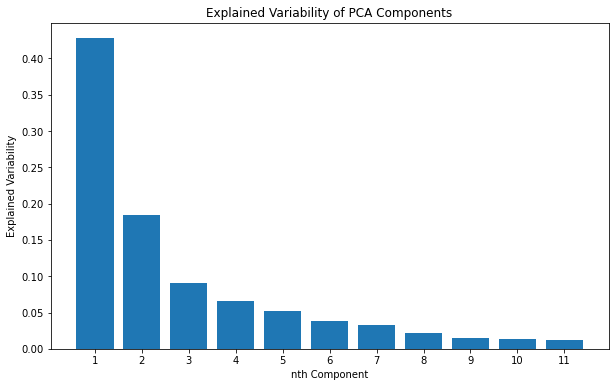

In [11]:
explained_variances = pca.explained_variance_ratio_

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, 12), explained_variances)
plt.xlabel('nth Component')
plt.ylabel('Explained Variability')
plt.title('Explained Variability of PCA Components')
plt.xticks(range(1, 12))
plt.show()

I kept 11 features in my prediction. These 11 features explains more than 95% of the variability of the dataset.

## 2. Train & tuning the XGBoost classification model

### Use random search to conduct a 5-fold validation finding fit parameters

In [12]:
classifier = xgb.XGBClassifier(objective ='binary:logistic')

In [13]:
param = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.25],'max_depth': [3, 4, 5],'subsample': [0.8, 0.9, 1.0]}

In [14]:
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = param, cv= 5, n_iter= 15, scoring = make_scorer(recall_score))
random_search.fit(X_train_pca, y_train)
best_model = random_search.best_estimator_

In [15]:
print(random_search.best_params_)
print(random_search.best_score_)

{'subsample': 0.9, 'max_depth': 4, 'learning_rate': 0.25}
0.9448863636363637


We see that the 5 fold give the result for best parameters as above. And the best valiodation score is around 98%

## 3. Test and evaluation XGB model


In [16]:
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9473684210526315

Since the training score and testing score are both high, the model isn't overfit. 

In [17]:
# see the confusion matrix for recall
confusion_matrix(y_test, y_pred)

array([[64,  1],
       [ 5, 44]])

In [18]:
recall_score(y_test, y_pred)

0.8979591836734694

In this case recall is a more important evaluation matric.

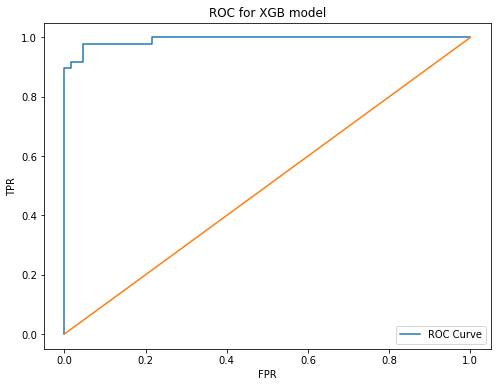

In [19]:
# See the ROC AOC curve for the model
y_pred_prob = best_model.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label='ROC Curve')
ax.plot([0, 1], [0, 1])
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC for XGB model')
ax.legend()
plt.show()

## Train Tune and Test Logistic Regression model

In [20]:
model_lr = LogisticRegression()

In [21]:
# Use RandomSearch to find optimal parameters
param = {'C': [0.01, 0.1, 1, 10, 100]}

grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=param, cv=5)
grid_search_lr.fit(X_train_pca, y_train)
best_params = grid_search_lr.best_params_
best_model_lr = LogisticRegression(**best_params)

best_model_lr.fit(X_train_pca, y_train)

LogisticRegression(C=1)

In [25]:
# Use logistic regression to predict for test data
y_pred = best_model_lr.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9824561403508771

In [28]:
#calculate recall score for logistic regression model
recall_score = recall_score(y_test, y_pred)
recall_score

0.9591836734693877

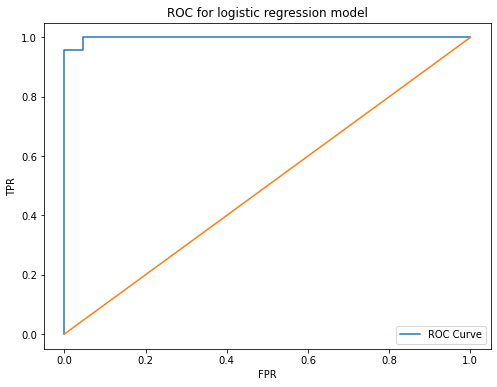

In [30]:
#draw roc_auc curve
y_prob = best_model_lr.predict_proba(X_test_pca)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label='ROC Curve')
ax.plot([0, 1], [0, 1])
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC for logistic regression model')
ax.legend()
plt.show()